In [1]:
LOAD_MODEL = 'models/transformer.01.pt'
MODEL_CHECKPOINT = 'models/transformer.01.pt'
DATASET_PATH = 'data/interim/preprocessed_paranmt3.tsv'

In [2]:
import numpy as np

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam

import os
os.chdir("..") # go to the root dir

## Get the Dataset

In [3]:
MAX_SENT_SIZE = 10
MAX_TOKENS = 25_000

In [4]:
from src.data.make_dataset import ParanmtDataset

train_dataset = ParanmtDataset(
    path=DATASET_PATH,
    max_sent_size=MAX_SENT_SIZE,
    train=True,
    seed=42,
)

In [5]:
train_dataset.build_vocab(
    min_freq=2,
    specials=['<unk>', '<pad>', '<sos>', '<eos>'],
    max_tokens=MAX_TOKENS,
)

In [6]:
enc_vocab = train_dataset.toxic_vocab
dec_vocab = train_dataset.neutral_vocab

In [7]:
print("size of encoder vocab:", len(enc_vocab))
print("size of decoder vocab:", len(dec_vocab))

size of encoder vocab: 12137
size of decoder vocab: 14544


In [8]:
val_dataset = ParanmtDataset(
    path=DATASET_PATH,
    max_sent_size=MAX_SENT_SIZE,
    vocabs=(enc_vocab, dec_vocab), # avoid data leakage
    train=False,
    seed=42,
    take_first=10_000,
)

In [9]:
len(train_dataset), len(val_dataset)

(162961, 10000)

## Let's create Dataloader

In [10]:
batch_size = 256

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [12]:
# let's check if shape and everything is ok
for batch in train_dataloader:
    toxic_sent, neutral_sent = batch
    print("toxic_sent.shape:", toxic_sent.shape)
    print("neutral_sent.shape:", neutral_sent.shape)
    break

toxic_sent.shape: torch.Size([256, 10])
neutral_sent.shape: torch.Size([256, 10])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load the Model

- Simple EncoderDecoder (Seq2Seq) architerture

In [14]:
# attention.py

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, heads, dropout, device):
        super(MultiHeadAttention, self).__init__()
        
        assert hidden_dim % heads == 0
        
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        
        self.heads = heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.heads_dim = hidden_dim // heads
        self.scale = torch.sqrt(torch.tensor(self.heads_dim)).to(device)
        
        
    def forward(self, query, key, value, mask=None, return_attention=False):
        # (key, value, query).shape: [batch_size, max_sent_size, hidden_dim]
        
        batch_size, max_sent_size, hidden_dim = key.shape
            
        key = self.fc_k(key).view(batch_size, -1, self.heads, self.heads_dim).permute(0, 2, 1, 3)
        value = self.fc_k(value).view(batch_size, -1, self.heads, self.heads_dim).permute(0, 2, 1, 3)
        query = self.fc_k(query).view(batch_size, -1, self.heads, self.heads_dim).permute(0, 2, 1, 3)
        # key.shape: [batch_size, heads, max_sent_size, heads_dim]
        
        energy = torch.matmul(query, key.permute(0, 1, 3, 2)) / self.scale
        # energy.shape: [batch_size, heads, max_sent_size, max_sent_size]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        
        x = torch.matmul(self.dropout(attention), value).permute(0, 2, 1, 3).contiguous()
        # x.shape: [batch_size, max_sent_size, heads, heads_dim]
        x = self.fc_o(x.view(batch_size, -1, self.hidden_dim))
        if return_attention:
            return x, attention
        return x

In [15]:
# encoder.py

class EncoderBlock(nn.Module):
    def __init__(self, hidden_dim, heads, ff_expantion, dropout, device):
        super(EncoderBlock, self).__init__()
        
        self.attention = MultiHeadAttention(hidden_dim, heads, dropout, device)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * ff_expantion),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim * ff_expantion, hidden_dim),
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # x.shape: [batch_size, max_sent_size, hidden_dim]
        
        _x = self.dropout(self.attention(x, x, x, mask))
        # _x.shape: [batch_size, max_sent_size, hidden_dim]
        
        x = self.norm1(_x + x)
        # x.shape: [batch_size, max_sent_size, hidden_dim]
        
        _x = self.dropout(self.ff(x))
        # _x.shape: [batch_size, max_sent_size, hidden_dim]
        
        x = self.norm2(_x + x)
        
        # _x.shape: [batch_size, max_sent_size, hidden_dim]
        return x
    
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, heads, ff_expantion, dropout, device, max_size, vocab):
        super(Encoder, self).__init__()
        
        self.padding_idx = vocab['<pad>']
        self.token_embedding = nn.Embedding(input_dim, hidden_dim, padding_idx=self.padding_idx)
        self.pos_embedding = nn.Embedding(max_size, hidden_dim)
        
        self.layers = nn.ModuleList([
            EncoderBlock(
                hidden_dim=hidden_dim,
                heads=heads,
                ff_expantion=ff_expantion,
                dropout=dropout,
                device=device,
            ) for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor(hidden_dim)).to(device)
        self.device = device
        self.vocab = vocab
        
    def forward(self, x, mask):
        # x.shape: [batch_size, max_sent_size]
        # mask.shape: [batch_size, max_sent_size]
        batch_size, max_sent_size = x.shape
        emb = self.token_embedding(x) * self.scale
        # emb.shape: [batch_size, max_sent_size, hidden_dim]
        pos = torch.arange(0, max_sent_size).reshape(1, max_sent_size).repeat(batch_size, 1).to(self.device)
        # pos.shape: [batch_size, max_sent_size]
        
        pos = self.pos_embedding(pos)
        # pos.shape: [batch_size, max_sent_size, hidden_dim]
        x = self.dropout(emb + pos)
        # x.shape: [batch_size, max_sent_size, hidden_dim]
        
        for layer in self.layers:
            x = layer(x, mask)
        
        # x.shape: [batch_size, max_sent_size, hidden_dim]
        return x

In [16]:
# decoder.py

class DecoderBlock(nn.Module):
    def __init__(self, hidden_dim, heads, ff_expantion, dropout, device):
        super(DecoderBlock, self).__init__()
        
        self.self_attention = MultiHeadAttention(
            hidden_dim,
            heads,
            dropout,
            device,
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.encoder_attention = MultiHeadAttention(hidden_dim, heads, dropout, device)
        
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * ff_expantion),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim * ff_expantion, hidden_dim),
        )
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, enc_out, src_mask=None, trg_mask=None, return_attention=False):
        # x.shape: [batch_size, max_sent_size]
        # enc_out.shape: [batch_size, max_sent_size, hidden_dim]
        # src_mask: [batch_size, max_sent_size]
        # trg_mask: [batch_size, max_sent_size]
        
        _x = self.dropout(self.self_attention(x, x, x, trg_mask))
        # _x.shape: [batch_size, max_sent_size, hidden_dim]
        
        x = self.norm1(_x + x)
        # x.shape: [batch_size, max_sent_size, hidden_dim]
        
        _x, attention = self.encoder_attention(x, enc_out, enc_out, src_mask, return_attention=True)
        
        x = self.norm2(self.dropout(_x) + x)
        
        x = self.norm3(self.dropout(self.ff(x)) + x)
        
        if return_attention:
            return x, attention
        return x
        

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, heads, ff_expantion, dropout, device, max_size, vocab):
        super(Decoder, self).__init__()
        self.padding_idx = vocab['<pad>']
        self.token_embedding = nn.Embedding(output_dim, hidden_dim, padding_idx=self.padding_idx)
        self.pos_embedding = nn.Embedding(max_size, hidden_dim)

        
        self.layers = nn.ModuleList([
            DecoderBlock(
                hidden_dim=hidden_dim,
                heads=heads,
                ff_expantion=ff_expantion,
                dropout=dropout,
                device=device,
            ) for _ in range(num_layers)])
        
        self.fc_out = nn.LazyLinear(output_dim)
        self.scale = torch.sqrt(torch.tensor(hidden_dim)).to(device)
        self.device = device
        self.vocab = vocab
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_out, src_mask, trg_mask, return_attention):
        # x.shape: [batch_size, max_sent_size]
        # src_mask.shape: [batch_size, max_sent_size]
        # trg_mask.shape: [batch_size, max_sent_size]
        batch_size, max_sent_size = x.shape
        
        emb = self.token_embedding(x)
        # emb.shape: [batch_size, max_sent_size, hidden_dim]
        
        pos = torch.arange(0, max_sent_size).reshape(1, max_sent_size).repeat(batch_size, 1).to(self.device)
        pos = self.pos_embedding(pos)
        x = self.dropout(emb * self.scale + pos)
        
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, trg_mask, return_attention=return_attention)
            if return_attention:
                x, attention = x
        
        x = self.fc_out(x)
        
        if return_attention:
            return x, attention
        
        return x
        

In [17]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, max_sent_size, device):
        super(Transformer, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.max_sent_size = max_sent_size
    
    def mask_src(self, x):
        # x.shape: [batch_size, max_sent_size]
        x = x.unsqueeze(1).unsqueeze(2)
        return (x != self.encoder.padding_idx)
    
    def mask_trg(self, x):
        # x.shape: [batch_size, max_sent_size]
        trg_pad_mask = (x != self.decoder.padding_idx).unsqueeze(1).unsqueeze(2)
        max_sent_size = x.shape[1]
        mask = torch.tril(torch.ones((max_sent_size, max_sent_size), device=self.device)).bool()
        return trg_pad_mask & mask
    
    def forward(self, src, trg, t=None, return_attention=False):
        # remove <eos> from trg
        trg = trg[:, :-1]
        
        src_mask = self.mask_src(src)
        trg_mask = self.mask_trg(trg)
        enc_output = self.encoder(src, src_mask)
        outputs = self.decoder(trg, enc_output, src_mask, trg_mask, return_attention=return_attention)
        return outputs
        

In [18]:
# configure some parameters for the model
heads = 4
hidden_dim = 256
ff_expantion = 4
max_size = MAX_SENT_SIZE

## Encoder
enc_input_dim = len(enc_vocab)
enc_dropout = 0.1
enc_num_layers = 3
enc_padding_idx = enc_vocab['<pad>']

## Decoder
dec_output_dim = len(dec_vocab)
dec_dropout = 0.1
dec_num_layers = 3
dec_padding_idx = dec_vocab['<pad>']

In [19]:
# load the encoder and decoder for our model
encoder = Encoder(
    input_dim=enc_input_dim,
    hidden_dim=hidden_dim,
    num_layers=enc_num_layers,
    heads=heads,
    ff_expantion=ff_expantion,
    dropout=enc_dropout,
    device=device,
    max_size=max_size,
    vocab=enc_vocab,
).to(device)

decoder = Decoder(
    output_dim=dec_output_dim,
    hidden_dim=hidden_dim,
    num_layers=dec_num_layers,
    heads=heads,
    ff_expantion=ff_expantion,
    dropout=dec_dropout,
    device=device,
    max_size=max_size,
    vocab=dec_vocab,
).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
best_loss = float('inf')

model = Transformer(
    encoder=encoder,
    decoder=decoder,
    device=device,
    max_sent_size=MAX_SENT_SIZE,
).to(device)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(ignore_index=decoder.padding_idx)

In [22]:
from src.models.train_model import train

best_loss = train(
    model=model,
    loaders=(train_dataloader, val_dataloader),
    optimizer=optimizer,
    criterion=criterion,
    epochs=5,
    device=device,
    best_loss=best_loss,
    ckpt_path=MODEL_CHECKPOINT,
)

Evaluating 5: 100%|██████████| 40/40 [00:00<00:00, 56.26it/s, loss=2.73]


In [94]:
# let's load the model and predict
model = torch.load(MODEL_CHECKPOINT)
model.to(device)
model.eval()
None

In [ ]:
# perform greed search to predict
def greedy_search(model, src):
    # src.shape: [batch_size, num_steps]
    batch_size = src.shape[0]
    if batch_size != 1:
        raise ValueError("it should be one sentence at a time, batch_size == 1")
    
    # we will use decoder vocab to get tokens
    vocab = model.decoder.vocab        
    max_sent_size = model.max_sent_size
    outputs = []
    
    # pass input through the encoder
    with torch.no_grad():
        encoder_out, hidden = model.encoder(src)

    eos_idx = vocab['<eos>']
    if use_encoder_out:
        context = encoder_out
    else:
        context = hidden.swapaxes(0, 1).clone()
    dec_in = torch.empty(batch_size, device=model.device, dtype=torch.long).fill_(vocab['<sos>'])
    with torch.no_grad():
        for i in range(max_sent_size):
            preds, hidden = model.decoder(dec_in, hidden, context)
            top1 = preds.argmax(1)
            if top1 == eos_idx:
                break
            outputs.append(top1.cpu().detach().numpy()[0])
            dec_in = top1

    return outputs

In [133]:
def greedy_search(model, src, return_attention=False):
    # src.shape: [batch_size, num_steps]
    batch_size = src.shape[0]
    if batch_size != 1:
        raise ValueError("it should be one sentence at a time, batch_size == 1")

    # we will use decoder vocab to get tokens
    vocab = model.decoder.vocab        
    max_sent_size = model.max_sent_size
    outputs = []
    model.eval()
    
    with torch.no_grad():
        # pass the src through the encoder
        src_mask = model.mask_src(src)
        enc_outputs = model.encoder(src, src_mask)
    
    eos_idx = model.decoder.vocab['<eos>']
    res = [model.decoder.vocab['<sos>']]
    with torch.no_grad():
        for t in range(1, max_sent_size):
            trg = torch.LongTensor(res).unsqueeze(0).to(device)
            
            trg_mask = model.mask_trg(trg)
            pred = model.decoder(trg, enc_outputs, src_mask, trg_mask, return_attention=return_attention)
            if return_attention:
                pred, attention = pred
            # pred.shape: [batch_size, max_sent_size, output_dim]
            
            top1 = pred[:, -1, :].argmax(1)
            res.append(top1.item())
            if top1 == eos_idx:
                break

    if return_attention:
        res = (res, attention)
    
    return res

In [134]:
src

tensor([[  2, 172,   6,  15,  11,  84,  29, 198,   4,   3]], device='cuda:0')

In [135]:
greedy_search(model, src)

[2, 141, 6, 14, 10, 61, 169, 4, 3]

In [136]:
beam_search(model, src)

[array([  2, 141,   6,  14,  10,  61, 169,   4,   3]),
 array([  2,  14,  10,  61, 169,   4,   3]),
 array([  2,  41,   6,  14,  10,  61, 169,   4,   3])]

In [26]:
from src.models.transformer.utils import preprocess_text, postprocess_text

def predict(src, model, post_process_text=True, return_attention=False):
    if type(src) is str:
        src = preprocess_text(src, max_sent_size=model.max_sent_size, vocab=model.encoder.vocab)
    src = src.to(model.device)
    batch_size = src.shape[0]

    if batch_size != 1:
        raise ValueError("batch_size should be one, i.e. one sentence at a time")

    model.eval()
    eos_idx = model.decoder.vocab['<eos>']
    with torch.no_grad():
        # pass the src through the encoder
        src_mask = model.mask_src(src)
        enc_outputs = model.encoder(src, src_mask)
        res = [model.decoder.vocab['<sos>']]
        for t in range(1, model.max_sent_size):
            trg = torch.LongTensor(res).unsqueeze(0).to(device)
            
            trg_mask = model.mask_trg(trg)
            # print("trg", trg)
            # print("trg_mask:", trg_mask)
            pred = model.decoder(trg, enc_outputs, src_mask, trg_mask, return_attention=return_attention)
            if return_attention:
                pred, attention = pred
            # pred.shape: [batch_size, max_sent_size, output_dim]
            
            
            top1 = pred[:, -1, :].argmax(1)
            res.append(top1.item())
            if top1 == eos_idx:
                break

    res = model.decoder.vocab.lookup_tokens(res[1:])
    if post_process_text:
        res = postprocess_text(res)
    if return_attention:
        res = (res, attention)
    
    return res

In [27]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

# let's see how our model works
num_examples = 10
df = val_dataset
for _ in range(num_examples):
    idx = np.random.randint(0, len(df))
    toxic_sent = detokenizer.detokenize(df.df.loc[idx, 'toxic_sent'])
    neutral_sent = detokenizer.detokenize(df.df.loc[idx, 'neutral_sent'])

    print('toxic_sent:', toxic_sent)
    print('neutral_sent:', neutral_sent)
    print('prediction:', predict(toxic_sent, model))
    print("\n")

toxic_sent: we will break them.
neutral_sent: we can take them.
prediction: we will take them.


toxic_sent: put your head between your legs.
neutral_sent: put your head in my lap.
prediction: put your head.


toxic_sent: be brave, frank, goddamn it!
neutral_sent: oh, be brave, frank.
prediction: be so, hell, man!


toxic_sent: like a 12 year old i dick.
neutral_sent: like a straw 12 year old.
prediction: like a old man.


toxic_sent: can i have a fag?
neutral_sent: can i have a cigarette?
prediction: can i have a bad?


toxic_sent: they will gas them anyway.
neutral_sent: they are gassed anyway.
prediction: they will be crazy.


toxic_sent: never let any chinese
neutral_sent: never let go, no chinaman.
prediction: never never never never die.


toxic_sent: what are you staring at, fucker?
neutral_sent: what are you looking at, punk?
prediction: what are you doing, man?


toxic_sent: she is a cow.
neutral_sent: she is a moose.
prediction: she is a bad.


toxic_sent: grace, this is ridi

In [121]:
from queue import PriorityQueue

### Beam Search Implementation
# beam search node, to reconstruct the output
class BeamNode:
    def __init__(self, dec_in, log_prob, length):
        self.dec_in = dec_in
        self.log_prob = log_prob
        self.length = length
        
    def eval(self, alpha=0.75):
        # alpha: more penalty for longer sentences
        return self.log_prob / (self.length ** alpha)
    
    def __ln__(self, other):
        return self.log_prob < other.log_prob
    
# perform beam search to predict
def beam_search(model, src, beam_width=5, num_candidates=3, max_steps=2000, max_candidate_coef=3):
    # if beam search by it self working slowly try to reduce `max_steps` or `max_candidate_coef`
    max_candidates = num_candidates * max_candidate_coef
    
    # init state
    q = PriorityQueue()
    qsize = 0
    candidates = []
    eos_idx = model.decoder.vocab['<eos>']
    sos_idx = model.decoder.vocab['<sos>']
    batch_size = src.shape[0]
    if batch_size != 1:
        raise ValueError("it should be one sentence at a time, batch_size == 1")
    
    # first steps
    with torch.no_grad():
        src_mask = model.mask_src(src)
        enc_outputs = model.encoder(src, src_mask)
    dec_in = torch.LongTensor([[sos_idx]]).to(model.device)
    node = BeamNode(dec_in, log_prob=0, length=1)
    q.put((-node.eval(), node))
    # start the beam search
    with torch.no_grad():
        while q.qsize() > 0 and qsize <= max_steps:
            score, node = q.get()
            # print(node.dec_in[:, -1])
            if node.dec_in[:, -1] == eos_idx and node.length > 1:
                candidates.append((score, node))
                if len(candidates) > max_candidates:
                    break
                continue
            if node.length > model.max_sent_size:
                continue
            
            trg_mask = model.mask_trg(node.dec_in)
            preds = model.decoder(node.dec_in, enc_outputs, src_mask, trg_mask, return_attention=False)
            # print("preds.shape:", preds.shape)
            preds = torch.log_softmax(preds[:, -1, :], dim=1)
            # print("preds.shape:", preds.shape)
            # take only top beam_width words
            topk, indices = torch.topk(preds, beam_width)
            # topk.shape: [1, beam_width]
            # print("topk.shape:", topk.shape)
            for i in range(beam_width):
                prob = topk[0][i].item()
                dec_in = indices[0][i].view(1, -1)
                dec_in = torch.cat((node.dec_in, dec_in), dim=1)
                next_node = BeamNode(
                    dec_in,
                    log_prob=node.log_prob + prob,
                    length=node.length + 1,
                )
                q.put((-next_node.eval(), next_node))
                
            qsize += beam_width - 1
    
    # if not enough answer, take from top of queue
    while len(candidates) < max_candidates and q.qsize() > 0:
        candidates.append(q.get())
        
    # sort candidates, and take first `num_candidates`
    candidates = sorted(candidates, key=lambda x: x[0])[:num_candidates]
    
    outputs = []
    for score, node in candidates:
        outputs.append(node.dec_in.cpu().detach().numpy()[0])
        
    return outputs

In [123]:
# let's take `idx`-th examle from val_dataset
idx = 6
src, trg = val_dataset[idx]
src = src.to(device).unsqueeze(0)
trg = trg.to(device).unsqueeze(0)

res = beam_search(model, src)

for sent in res:
    print(model.decoder.vocab.lookup_tokens(sent))

['<sos>', 'well', ',', 'it', 'is', 'about', 'time', '.', '<eos>']
['<sos>', 'it', 'is', 'about', 'time', '.', '<eos>']
['<sos>', 'oh', ',', 'it', 'is', 'about', 'time', '.', '<eos>']


## Let's visualize the attention weights

In [68]:
# from src.visualize import diplay_attention

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,10))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+[t.lower() for t in sentence], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [89]:
# let's take `idx`-th examle from val_dataset
idx = 6
src, trg = val_dataset[idx]
src = src.to(device).unsqueeze(0)
trg = trg.to(device).unsqueeze(0)
print(src.shape)
pred, attention = predict(src, model, return_attention=True, post_process_text=False)


torch.Size([1, 10])


In [90]:
src = src.cpu().detach().numpy()[0]
src = enc_vocab.lookup_tokens(src)

In [91]:
print(src)

['<sos>', 'well', ',', 'it', 'is', 'about', 'damn', 'time', '.', '<eos>']


In [92]:
print(pred)

['well', ',', 'it', 'is', 'about', 'time', '.', '<eos>']


/tmp/ipykernel_880/3350471769.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+[t.lower() for t in sentence],
/tmp/ipykernel_880/3350471769.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


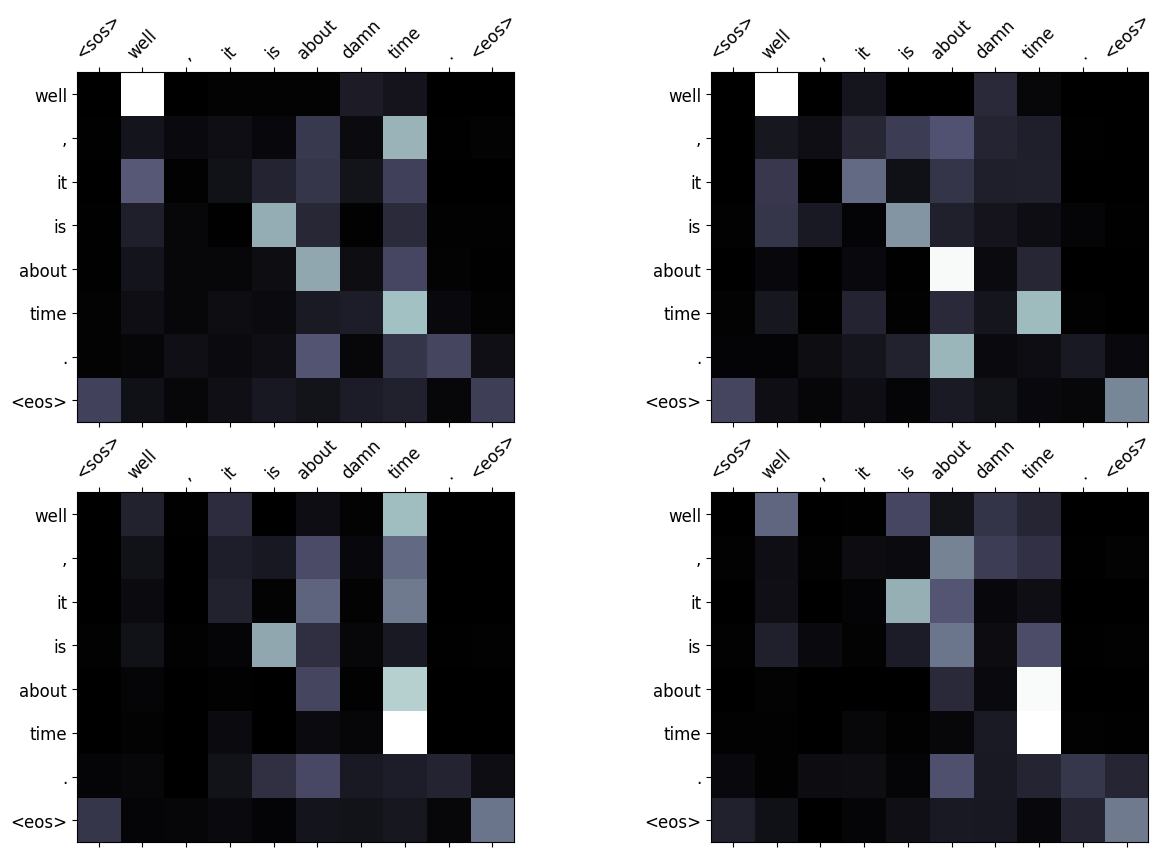

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

display_attention(src, pred, attention, n_heads=4, n_rows=2, n_cols=2)